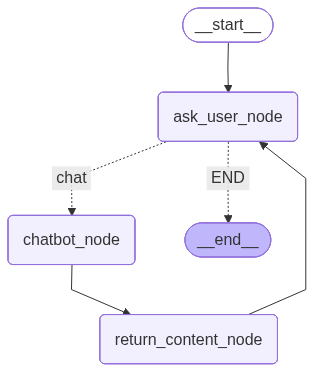

In [8]:

from IPython.display import Image, display
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, START, END
from langchain.chat_models import init_chat_model
from langchain.messages import HumanMessage, AIMessage, SystemMessage
from dotenv import load_dotenv


class State(TypedDict):
    messages: Annotated[list, add_messages]


load_dotenv()
llm = init_chat_model(
    "gemini-2.5-flash",
    model_provider="google_genai",
    temperature=0
)

graph = StateGraph(State)


def ask_user(state: State) -> State:
    user_input = input("Please enter your question:")

    return {
        'messages': [HumanMessage(content=user_input)]
    }

def router(state:State)-> str:
    last_user_message = state['messages'][-1].content.lower()
    if "exit" in last_user_message:
        return "END"
    else:
        return "chat"


def chatbot(state: State) -> State:
    response = llm.invoke(state['messages'])
    return {
        'messages': [AIMessage(content=response.content)]
    }


def return_content(state: State) -> State:
    print("Chatbot response:", state['messages'][-1].content)
    return state


graph.add_node("ask_user_node", ask_user)
graph.add_node("chatbot_node", chatbot)
graph.add_node("return_content_node", return_content)
graph.add_edge(START, "ask_user_node")
graph.add_conditional_edges("ask_user_node",router,{
"END": END,
"chat" : "chatbot_node"
})
graph.add_edge("chatbot_node", "return_content_node")
graph.add_edge("return_content_node", "ask_user_node")

builder = graph.compile()


display(Image(builder.get_graph().draw_mermaid_png()))



In [ ]:
builder.invoke({"messages":[]})